In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import os
import nibabel as nib

In [ ]:
# Elastic Distortion
def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    return distorted_image

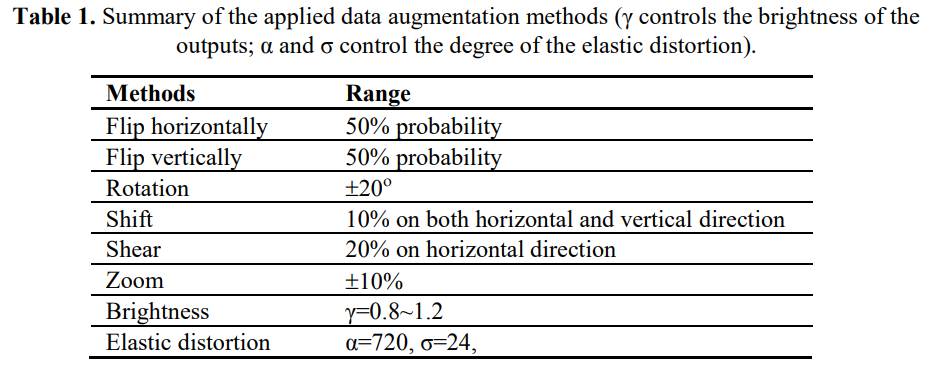

In [ ]:
def augment_image(image):
    if random.random() > 0.5:  # 50% 확률로 좌우 대칭 (Flip horizontally)
        image = np.fliplr(image)
    if random.random() > 0.5:  # 50% 확률로 상하 대칭 (Flip vertically)
        image = np.flipud(image)
    # 랜덤 회전 (±20도)
    angle = random.uniform(-20, 20)
    image = tf.keras.preprocessing.image.random_rotation(image, angle)
    # 랜덤 이동 (shift: 10% both directions)
    shift_range = 0.1 * np.array(image.shape[:2])
    image = tf.keras.preprocessing.image.random_shift(image, shift_range[0], shift_range[1], row_axis=0, col_axis=1, channel_axis=2)
    # 랜덤 확대/축소 (zoom ±10%)
    image = tf.keras.preprocessing.image.random_zoom(image, (0.9, 1.1))
    # 밝기 조정 (γ=0.8~1.2)
    gamma = random.uniform(0.8, 1.2)
    image = np.power(image, gamma)
    # Elastic Distortion (α=720, σ=24)
    image = elastic_transform(image, alpha=720, sigma=24)
    return image

In [ ]:
# NIfTI 파일 로드
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

In [ ]:
def load_brats_patient(patient_id, data_dir):
    flair = load_nifti_image(os.path.join(data_dir, patient_id, patient_id + '_flair.nii.gz'))
    t1 = load_nifti_image(os.path.join(data_dir, patient_id, patient_id + '_t1.nii.gz'))
    t1ce = load_nifti_image(os.path.join(data_dir, patient_id, patient_id + '_t1ce.nii.gz'))
    t2 = load_nifti_image(os.path.join(data_dir, patient_id, patient_id + '_t2.nii.gz'))
    seg = load_nifti_image(os.path.join(data_dir, patient_id, patient_id + '_seg.nii.gz'))

    # 78번은 임의의 값 (슬라이드)
    flair_resized = cv2.resize(flair[:, :, 78], (240, 240))
    t1_resized = cv2.resize(t1[:, :, 78], (240, 240))
    t1ce_resized = cv2.resize(t1ce[:, :, 78], (240, 240))
    t2_resized = cv2.resize(t2[:, :, 78], (240, 240))

    input_data = np.stack([flair_resized, t1_resized, t1ce_resized, t2_resized], axis=-1)
    label_data = cv2.resize(seg[:, :, 78], (240, 240))
    label_data = np.expand_dims(label_data, axis=-1)

    # 라벨을 one-hot 인코딩으로 변환
    label_data = np.where(label_data > 0, 1, 0)  # 종양 있는 부분은 1, 나머지는 0
    label_data = tf.keras.utils.to_categorical(label_data, num_classes=2)  # 2개의 클래스 (배경과 종양)

    return input_data, label_data

In [ ]:
# 데이터셋에서 배치를 생성하는 제너레이터
def data_generator(patient_ids, data_dir, batch_size=4, augment=True):
    while True:
        for i in range(0, len(patient_ids), batch_size):
            batch_ids = patient_ids[i:i+batch_size]
            batch_input = []
            batch_label = []
            for patient_id in batch_ids:
                input_data, label_data = load_brats_patient(patient_id, data_dir)
                # 데이터 증강 적용
                if augment:
                    input_data = augment_image(input_data)
                batch_input.append(input_data)
                batch_label.append(label_data)
            yield np.array(batch_input), np.array(batch_label)

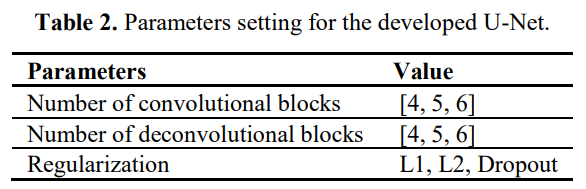

In [ ]:
# U-Net 모델 정의 (업샘플링 시 크기 맞춤 적용)
def unet(input_size=(240, 240, 4), num_conv_blocks=5, regularization='l2', dropout_rate=0):
    inputs = layers.Input(input_size)

    # Regularization 설정
    if regularization == 'l1':
        regularizer = regularizers.l1(1e-5)
    elif regularization == 'l2':
        regularizer = regularizers.l2(1e-5)
    else:
        regularizer = None

    # Down-sampling
    conv_blocks = []
    filters = 64
    for i in range(num_conv_blocks):
        # 모든 가중치는 평균이 0이고 표준 편차가 0.01인 정규 분포로 초기화되었으며, 모든 바이어스는 0으로 초기화 (적용 코드)
        conv = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=regularizer,
                             kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                             bias_initializer='zeros')(inputs if i == 0 else pool)
        conv = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=regularizer,
                             kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                             bias_initializer='zeros')(conv)
        pool = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv)
        conv_blocks.append(conv)
        filters *= 2

    # Middle block
    middle = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=regularizer,
                           kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                           bias_initializer='zeros')(pool)
    middle = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=regularizer,
                           kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                           bias_initializer='zeros')(middle)

    # Up-sampling
    filters //= 2
    for i in range(num_conv_blocks - 1, -1, -1):
        up = layers.Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(middle if i == num_conv_blocks - 1 else conv_up)

        # 크기 일치를 위해 필요한 경우 Cropping2D 적용
        conv_block = conv_blocks[i]
        if conv_block.shape[1] != up.shape[1] or conv_block.shape[2] != up.shape[2]:
            up = layers.Cropping2D(((0, up.shape[1] - conv_block.shape[1]), (0, up.shape[2] - conv_block.shape[2])))(up)
            # up = layers.Conv2DTranspose(filters, 2, strides=(2, 2), padding='same',
            #                         kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
            #                         bias_initializer='zeros')(middle if i == num_conv_blocks - 1 else conv_up)

        merge = layers.concatenate([conv_block, up], axis=3)
        conv_up = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=regularizer,
                                kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                                bias_initializer='zeros')(merge)
        conv_up = layers.Conv2D(filters, 3, activation='relu', padding='same', kernel_regularizer=regularizer,
                                kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                                bias_initializer='zeros')(conv_up)
        if dropout_rate > 0:
            conv_up = layers.Dropout(dropout_rate)(conv_up)
        filters //= 2

    conv_output = layers.Conv2D(2, 1, activation='softmax')(conv_up)

    model = models.Model(inputs=inputs, outputs=conv_output)

    return model

In [ ]:
def create_unet_model(num_conv_blocks=5, regularization='l2', dropout_rate=0):
    model = unet(input_size=(240, 240, 4), num_conv_blocks=num_conv_blocks, regularization=regularization)
    return model

In [ ]:
# Soft Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=2)  # depth는 클래스 수

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Training Data Load

Training Data 늘렸으나 결과 변화 X

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# train data directory
data_dir = '/content/drive/My Drive/Colab Notebooks/Paper_review/MRI_data/BraTS2021_Training_Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_patient_folders(data_dir):
    patient_folders = set()
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            folder_name = os.path.basename(os.path.dirname(os.path.join(root, file)))  # Get folder name
            patient_folders.add(folder_name)
    return sorted(patient_folders)  # Return a sorted list of folder names

# Get the patient folder names (IDs)
patient_ids = get_patient_folders(data_dir)

print(patient_ids)

['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00008', 'BraTS2021_00009', 'BraTS2021_00011', 'BraTS2021_00012', 'BraTS2021_00014', 'BraTS2021_00016', 'BraTS2021_00017', 'BraTS2021_00018', 'BraTS2021_00019', 'BraTS2021_00020', 'BraTS2021_00021', 'BraTS2021_00022', 'BraTS2021_00024', 'BraTS2021_00025', 'BraTS2021_00026', 'BraTS2021_00028', 'BraTS2021_00030', 'BraTS2021_00031', 'BraTS2021_00032', 'BraTS2021_00033', 'BraTS2021_00035', 'BraTS2021_00036', 'BraTS2021_00043', 'BraTS2021_00044', 'BraTS2021_00045', 'BraTS2021_00046', 'BraTS2021_00048', 'BraTS2021_00049', 'BraTS2021_00051', 'BraTS2021_00052', 'BraTS2021_00053', 'BraTS2021_00054', 'BraTS2021_00056', 'BraTS2021_00058', 'BraTS2021_00059', 'BraTS2021_00060', 'BraTS2021_00061', 'BraTS2021_00062', 'BraTS2021_00063', 'BraTS2021_00064', 'BraTS2021_00066', 'BraTS2021_00068', 'BraTS2021_00070', 'BraTS2021_00071', 'BraTS2021_00072', 'BraTS2021_00074', 'BraTS2021_00077', 'BraTS2021_

In [ ]:
train_generator = data_generator(patient_ids, data_dir, augment=True)

In [ ]:
# 모델 생성 및 컴파일
model = create_unet_model(num_conv_blocks=5, regularization='l2', dropout_rate=0.3)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_loss, metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
history = model.fit(train_generator, steps_per_epoch=10, epochs=5)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2881 - loss: 0.6126
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 371s 37s/step - accuracy: 0.0339 - loss: 0.6090
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 372s 37s/step - accuracy: 0.0353 - loss: 0.6034
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 381s 38s/step - accuracy: 0.0258 - loss: 0.5939
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 375s 37s/step - accuracy: 0.0233 - loss: 0.5692
Epoch 6/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 6:05 41s/step - accuracy: 0.0055 - loss: 0.4865

KeyboardInterrupt: 

# Result

In [ ]:
import matplotlib.pyplot as plt

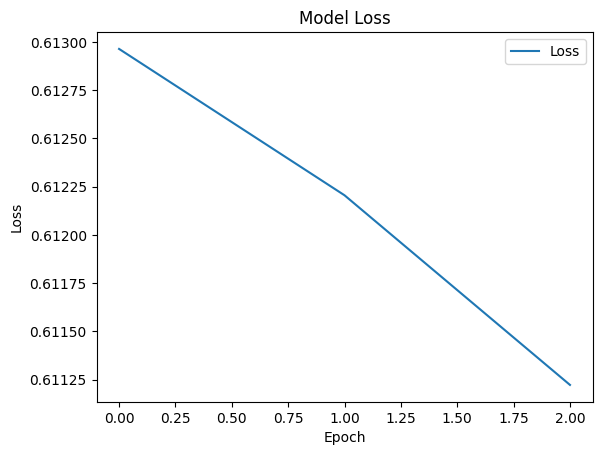

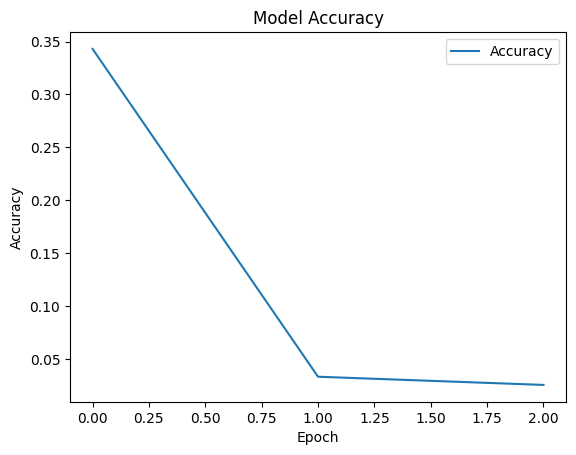

In [ ]:
# 결과 시각화: 손실 및 정확도
def plot_training_history(history):
    # 손실 그래프
    plt.plot(history.history['loss'], label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 정확도 그래프
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)

In [ ]:
# 테스트할 환자 ID와 데이터 경로
data_dir = 'test/'  # BRATS 데이터셋이 저장된 디렉토리
patient_id = 'BraTS2021_00495'

In [ ]:
# 예측 결과 시각화 함수
def display_prediction(patient_id, data_dir, model):
    input_data, true_label = load_brats_patient(patient_id, data_dir)
    input_data = np.expand_dims(input_data, axis=0)  # 배치 차원 추가

    # 예측
    pred = model.predict(input_data)
    pred_label = np.argmax(pred, axis=-1)[0]  # 예측 라벨 (0 또는 1)

    # 결과 시각화
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(input_data[0, :, :, 0], cmap='gray')  # FLAIR 이미지
    plt.title("FLAIR Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_label[:, :, 0], cmap='gray')  # 실제 라벨 (Ground Truth)
    plt.title("Ground Truth Label")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_label, cmap='gray')  # 예측된 라벨
    plt.title("Predicted Label")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


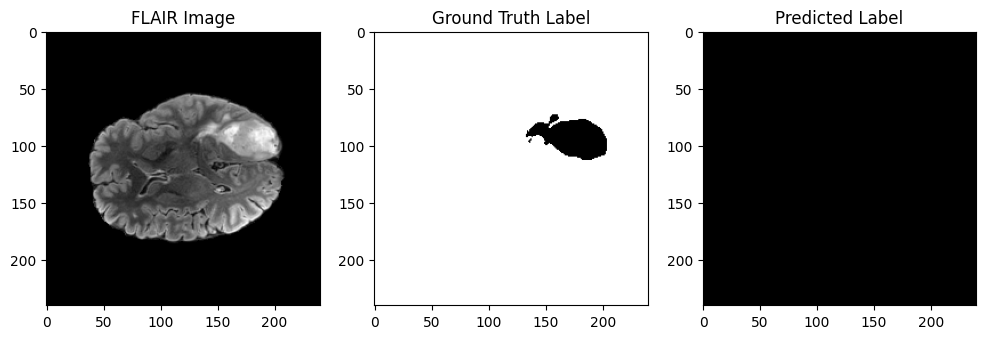

In [ ]:
# 함수 실행 (예측 결과 확인)
display_prediction(patient_id, data_dir, model)